# Tsiky Tafita RAKOTOHERISOA 

## Mini-project 

## Big Data 

#### Useful libraries

In [1]:
## Python setup
from datetime import datetime
from IPython.display import Image
import pandas as pd
# Suppress scientific notation globally
pd.options.display.float_format = '{:.2f}'.format
import numpy as np
from pathlib import Path
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark import SparkContext, SparkConf

from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier, DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import VectorAssembler

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression as LR
from sklearn.ensemble import RandomForestClassifier as RF, GradientBoostingClassifier as GBM, ExtraTreesClassifier as ETC, AdaBoostClassifier as Ada
from sklearn.metrics import accuracy_score, classification_report, accuracy_score
from tabulate import tabulate
import matplotlib.pyplot as plt
import seaborn as sns

# Task1: Loading and subsetting data

### Loading the dataset using spark

In [2]:
# Initialize Spark session
spark = SparkSession.builder.appName("SampleData").getOrCreate()

# Enable Arrow for faster conversion
spark.conf.set("spark.sql.execution.arrow.pyspark.enabled", "true")

# Read the full dataset
df = spark.read.csv("population-project-dataset/ResidentIBEIPM.csv", header=True, inferSchema=True)

# Sampling the data
df_sampled = df.sample(fraction=0.05,seed = 42)

### Writing the dataset as csv file 

In [3]:
output_path = "datasets"

df_sampled.repartition(10).coalesce(1).write.csv(output_path, header=True, sep=",", mode="overwrite")

In [4]:
dataset = Path('dataset')
csv_file_names = [file.name for file in dataset.glob('*.csv')]

In [5]:
csv_file_names

['part-00000-e06923c3-9dc3-43ae-8323-7d7018fe43b3-c000.csv']

### Reading the data using pandas

In [6]:
if csv_file_names:
    
    data = pd.read_csv(f"dataset/{csv_file_names[0]}")

/usr/lib/python3/dist-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (171) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [7]:
data.head()

,C06,C07,PROVINCE,REGION,DISTRICT,COMMUNES,MILIEU,MilieuCarto,IDMEN,IDINDIV,...,wcounth,wcounte,wcountlc,wcount,poorhh,mpih,mpia,mpi,vulne,severe
0,42,3,1,11,111,11101,1,1,11101101420031165023190319,1110110142003116503190231901,...,0.00,0.00,0.13,0.13,0,0,nan,0.00,0,0
1,14,2,1,11,111,11101,1,1,11101101140021120022760276,1110110114002112002760227601,...,0.00,0.00,0.07,0.07,0,0,nan,0.00,0,0
2,10,1,1,11,111,11101,1,1,11101101100011045022050205,1110110110001014502050220506,...,0.00,0.00,0.07,0.07,0,0,nan,0.00,0,0
3,15,1,1,11,111,11101,1,1,11101101150011105020480048,1110110115001110500480204802,...,0.00,0.00,0.13,0.13,0,0,nan,0.00,0,0
4,3,4,1,11,111,11101,1,1,11101101030041003020670067,1110110103004010300670206705,...,0.00,0.17,0.27,0.43,100,100,43.33,0.43,0,0


In [8]:
print(f"Now we have {len(data.columns)} number of features.")

Now we have 203 number of features.


### Rename the columns of the dataframe for easy identification (based on the task description in the notebook)

In [9]:
df1 = data.rename(columns={
    'P05': 'sex',
    'P03': 'HouseHoldRelationship',
    'P08': 'age',
    'P28': 'maritalStatus',
    'P29': 'ageAtFirstMarriage',
    'P21': 'schoolAttendance',
    'P22N': 'HighSchoolLevAttendance',
    'P22C': 'yearOfSchool',
    'P23': 'WorkStatus'
})


In [10]:
df2 = df1.copy()  # Make a copy to preserve the original DataFrame

# Create the 'LanguageSpoken' column by summing relevant columns
df2['LanguageSpoken'] = df2['P19MG'] + df2['P19FR'] + df2['P19AN'] + df2['P19AU']

# Create the 'Literacy' column by summing relevant columns
df2['Literacy'] = df2['P20MG'] + df2['P20FR'] + df2['P20AN'] + df2['P20AU']


### Define the columns to keep

I choose these columns based on what are the columns that make in sense with our task and based on the description of the task in the starter notebook. 

In [11]:
columns_to_keep = [
    'sex', 
    'HouseHoldRelationship', 
    'age', 
    'maritalStatus', 
    'ageAtFirstMarriage', 
    'schoolAttendance', 
    'HighSchoolLevAttendance', 
    'yearOfSchool', 
    'WorkStatus', 
    'LanguageSpoken', 
    'Literacy',
    'PROVINCE',
    'REGION',
    'DISTRICT',
    'COMMUNES',
    'MILIEU',
    'MilieuCarto',
    'IDMEN',
    'IDINDIV'
]

# Keep only the specified columns
df3 = df2[columns_to_keep]


In [12]:
print(f"Now we have {len(df3.columns)} number of features.")


Now we have 19 number of features.


### Strategy that I use:

- Firstly I use a **sampling strategy**. It is employed using Apache Spark to extract just a representative sample.

- Furthurmore, **reducing memory usage and processing time while maintaining data integrity**. This allows us for exploratory analysis and model development without overwhelming system resources.

- And also Apache Spark is utilized for distributed processing, enabling parallel computation across multiple cores. So, one of my solution for loading the data is using **Arrow optimization.**

It is enabled to accelerate data conversion between Spark and Pandas, improving processing efficiency.

- **Column selection and filtering**. 

The reason why I choose to use these features are because these are the columns that make in sense with the task, meaningful. 


- **Conversion to Pandas for local analysis**

- **Storage and caching optimization**

This approach balances scalability and performance, allowing for iterative data processing and model refinement without memory constraints.


# Task2: Data preprocessing 

### Adding new variables [column household size]

Household size refers to the number of people in a household. The dataset provides a household identifier (hh_id) and an individual identifier (indiv_id). Using these, we can generate a new column called household_size

In [13]:
import pandas as pd

def gen_var_hh_size(df):
    """
    Generates variables for household size, number of children, and number of elderly using 'IDMEN' as the household identifier.
    
    Parameters
    ----------
    df : DataFrame
        The input Pandas DataFrame containing household data.
    
    Returns
    -------
    DataFrame
        A DataFrame with new features: `hh_size`, `num_children`, `num_elderly`.
    """
    
    # ======================================================
    # Generate HH Size: Count number of individuals in each household (IDMEN)
    # ======================================================
    hh_size = df.groupby('IDMEN')['IDINDIV'].transform('count')
    df['hh_size'] = hh_size
    
    # ======================================================
    # Generate Number of Children: Assuming 'age' column exists and represents age
    # Considering children as individuals below 18 years old
    # ======================================================
    df['num_children'] = df[df['age'] < 18].groupby('IDMEN')['IDINDIV'].transform('count')
    df['num_children'] = df['num_children'].fillna(0).astype(int)
    
    # ======================================================
    # Generate Number of Elderly: Considering individuals aged 65 or older
    # ======================================================
    df['num_elderly'] = df[df['age'] >= 65].groupby('IDMEN')['IDINDIV'].transform('count')
    df['num_elderly'] = df['num_elderly'].fillna(0).astype(int)
    
    # ======================================================
    # Return the DataFrame with new features
    # ======================================================
    return df


In [14]:
df4 = gen_var_hh_size(df3)  

<ipython-input-13-f77258de2116>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['hh_size'] = hh_size
<ipython-input-13-f77258de2116>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['num_children'] = df[df['age'] < 18].groupby('IDMEN')['IDINDIV'].transform('count')
<ipython-input-13-f77258de2116>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas

In [15]:
print(f"Now we have {len(df4.columns)} number of features.")

Now we have 22 number of features.


### Checking for the nan values in the dataset

In [16]:
nan_check = df4.isna().sum().sum()
print(f"Total number of NaN values in the DataFrame: {nan_check}")


Total number of NaN values in the DataFrame: 2504073


### Handling with the missing values by filling with the mode for categorical variables and mean for continuous variables

In [17]:

for column in df4.columns:
    if df4[column].dtype == 'object':  
        
        df4[column].fillna(df4[column].mode()[0], inplace=True)
    else:  
        
        df4[column].fillna(df4[column].mean(), inplace=True)


/usr/lib/python3/dist-packages/pandas/core/series.py:4530: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


In [18]:
nan_check = df4.isna().sum().sum()
print(f"Total number of NaN values in the DataFrame: {nan_check}")


Total number of NaN values in the DataFrame: 0


# Task3: Exploratory data analysis

### Perform exploratory analysis to understand the data based on the task at hand. Provide a brief explanation of which variables you will explore and why [200 words]


For the performance of the exploratory analysis, I check these three points:

- Summary statistics: to well understand the behaviour of the data

- Histogram of age at first marriage, age, sex: in order to understand more about the repartition of these variables.

### Summary statistics

In [19]:
df4.describe()

,sex,HouseHoldRelationship,age,maritalStatus,ageAtFirstMarriage,schoolAttendance,HighSchoolLevAttendance,yearOfSchool,WorkStatus,LanguageSpoken,Literacy,PROVINCE,REGION,DISTRICT,COMMUNES,MILIEU,MilieuCarto,hh_size,num_children,num_elderly
count,1282730.00,1282730.00,1282730.00,1282730.00,1282730.00,1282730.00,1282730.00,1282730.00,1282730.00,1282730.00,1282730.00,1282730.00,1282730.00,1282730.00,1282730.00,1282730.00,1282730.00,1282730.00,1282730.00,1282730.00
mean,1.51,1.94,22.36,1.73,20.71,1.10,2.39,3.04,3.00,6.68,6.89,2.92,31.24,315.73,31581.88,1.81,1.78,1.22,0.55,0.03
std,0.50,1.97,17.81,0.57,3.18,1.02,0.65,1.37,2.06,0.61,0.93,1.68,16.74,167.37,16737.21,0.39,0.42,0.47,0.62,0.16
min,1.00,0.00,0.00,1.00,8.00,0.00,1.00,0.00,1.00,4.00,4.00,1.00,11.00,111.00,11101.00,1.00,1.00,1.00,0.00,0.00
25%,1.00,1.00,8.00,1.00,20.00,1.00,2.00,2.00,1.00,6.68,6.00,1.00,13.00,133.00,13303.00,2.00,2.00,1.00,0.00,0.00
50%,2.00,2.00,18.00,1.73,20.71,1.00,2.39,3.04,3.00,7.00,7.00,3.00,31.00,312.00,31202.00,2.00,2.00,1.00,0.00,0.00
75%,2.00,2.00,33.00,2.00,20.71,2.00,2.39,4.00,5.00,7.00,8.00,4.00,44.00,441.00,44115.00,2.00,2.00,1.00,1.00,0.00
max,2.00,9.00,95.00,4.00,98.00,9.00,5.00,8.00,8.00,8.00,8.00,6.00,62.00,624.00,62418.00,2.00,2.00,6.00,5.00,3.00


### Histogram of age at first marriage

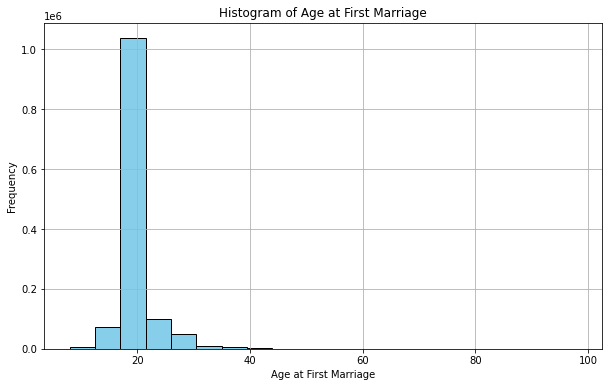

In [20]:

plt.figure(figsize=(10, 6))
plt.hist(df4['ageAtFirstMarriage'], bins=20, edgecolor='black', color='skyblue')
plt.title('Histogram of Age at First Marriage')
plt.xlabel('Age at First Marriage')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


### Frequency table for age at first marriage 

In [21]:
age_married_table = df4['ageAtFirstMarriage'].value_counts().reset_index()
age_married_table.columns = ['Age at First Marriage', 'Frequency']

# Display the table
print(age_married_table)


    Age at First Marriage  Frequency
0                   20.71     766503
1                   20.00      85593
2                   18.00      75279
3                   19.00      44018
4                   17.00      39273
..                    ...        ...
75                  79.00          1
76                  85.00          1
77                  81.00          1
78                  78.00          1
79                  74.00          1

[80 rows x 2 columns]


**Observations:** The data shows that the most common age at first marriage is around 20 years, with the highest frequency at 20.71 years (766,503 individuals), indicating a trend of early marriages.

There are very few cases of late marriages, with ages like 74 to 85 having only one occurrence each, suggesting they are rare outliers.

### Histogram of variable sex

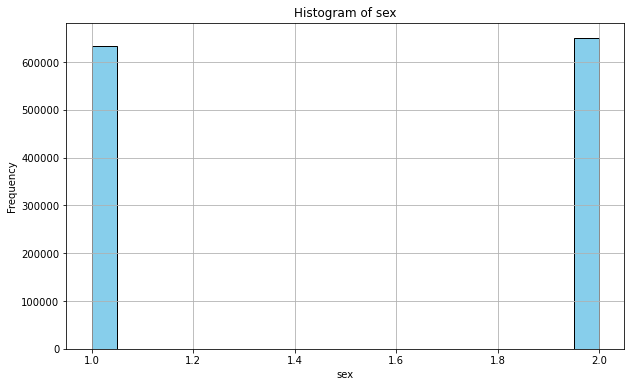

In [22]:
plt.figure(figsize=(10, 6))
plt.hist(df4['sex'], bins=20, edgecolor='black', color='skyblue')
plt.title('Histogram of sex')
plt.xlabel('sex')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


### Frequency table for the variable sex

In [23]:
sex_table = df4['sex'].value_counts().reset_index()
sex_table.columns = ['sex', 'Frequency']

# Display the table
print(sex_table)

   sex  Frequency
0    2     649961
1    1     632769


**Observations:** The repartition of the sex is well distributed. There is no big difference between the two class of sex.

### Histogram of age

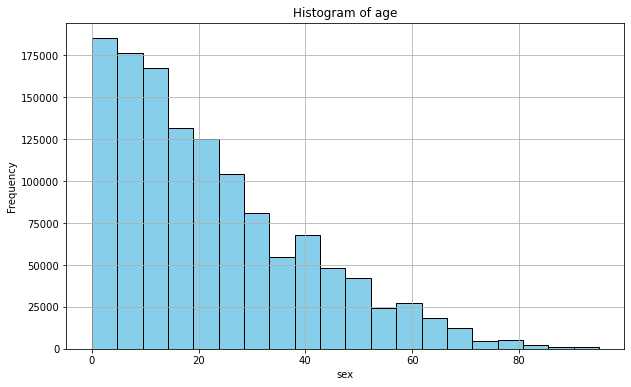

In [24]:
plt.figure(figsize=(10, 6))
plt.hist(df4['age'], bins=20, edgecolor='black', color='skyblue')
plt.title('Histogram of age')
plt.xlabel('sex')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

### Frequency table of age

In [25]:
age_table = df4['age'].value_counts().reset_index()
age_table.columns = ['age', 'Frequency']

# Display the table
print(age_table)

     age  Frequency
0  10.00      40356
1  18.00      39491
2   2.00      39458
3   3.00      38503
4   4.00      38490
..   ...        ...
92 91.00         68
93 92.00         60
94 93.00         54
95 94.00         51
96 22.36         38

[97 rows x 2 columns]


**Observations:** According to this frequency table, there is a big variation of the age in the dataset 

# Task4: Prepare data for ML model building

### Deal with outliers in continuous variables

In [26]:
# Drop all observations with age > 100
df4 = df4[df4['age'] <= 100]

# Drop all observations with hh_size > 20
df4 = df4[df4['hh_size'] <= 20]

# Drop all observations with num_children > 1
df4 = df4[df4['num_children'] <= 1]

# Drop all observations with num_elderly > 1
df4 = df4[df4['num_elderly'] <= 1]

In [27]:
# Verify the changes
print(df4[['age', 'hh_size', 'num_children', 'num_elderly']].describe())

             age    hh_size  num_children  num_elderly
count 1207938.00 1207938.00    1207938.00   1207938.00
mean       23.19       1.16          0.45         0.03
std        17.93       0.40          0.50         0.16
min         0.00       1.00          0.00         0.00
25%         9.00       1.00          0.00         0.00
50%        19.00       1.00          0.00         0.00
75%        34.00       1.00          1.00         0.00
max        95.00       6.00          1.00         1.00


In [28]:
df4.columns

Index(['sex', 'HouseHoldRelationship', 'age', 'maritalStatus',
       'ageAtFirstMarriage', 'schoolAttendance', 'HighSchoolLevAttendance',
       'yearOfSchool', 'WorkStatus', 'LanguageSpoken', 'Literacy', 'PROVINCE',
       'REGION', 'DISTRICT', 'COMMUNES', 'MILIEU', 'MilieuCarto', 'IDMEN',
       'IDINDIV', 'hh_size', 'num_children', 'num_elderly'],
      dtype='object')

### Checking outliers using boxplots

In [29]:

# Drop rows where age > 100
df4 = df4[df4["age"] <= 100]

# Drop rows where hh_size > 20
df4 = df4[df4["hh_size"] <= 20]

# Drop rows where num_children > 1
df4 = df4[df4["num_children"] <= 1]

# Drop rows where num_elderly > 1
df4 = df4[df4["num_elderly"] <= 1]


### Generate Target Variable for Prediction

In [30]:
# Define the early marriage age threshold
EARLY_MARRIAGE_AGE_THRESHOLD = 18

# Add early_marriage variable
df4['early_marriage'] = df4['ageAtFirstMarriage'].apply(lambda x: 1 if x < EARLY_MARRIAGE_AGE_THRESHOLD else 0)


### One-hot encoding for categorical variables

In [31]:
# ============================================
# ONE-HOT ENCODING FOR CATEGORICAL VARIABLES
# ============================================

categorical_columns = [
    'sex', 'HouseHoldRelationship', 'maritalStatus', 'schoolAttendance', 
    'HighSchoolLevAttendance', 'WorkStatus', 'PROVINCE',
    'schoolAttendance', 'MILIEU'
]

for col in categorical_columns:
    df4[col] = df4[col].astype('category')


In [32]:
categorical_columns

['sex',
 'HouseHoldRelationship',
 'maritalStatus',
 'schoolAttendance',
 'HighSchoolLevAttendance',
 'WorkStatus',
 'PROVINCE',
 'schoolAttendance',
 'MILIEU']

In [33]:
# One-hot encode categorical variables using pd.get_dummies
df4 = pd.get_dummies(df4, columns=categorical_columns, drop_first=True)


In [34]:
# Convert True/False columns to 1/0 (if any)
df4 = df4.applymap(lambda x: 1 if x is True else (0 if x is False else x))

In [35]:
# Verify the changes by checking the columns and first few rows
print(df4.head())

    age  ageAtFirstMarriage  yearOfSchool  LanguageSpoken  Literacy  REGION  \
0 55.00               27.00          8.00            5.00      5.00      11   
1 64.00               22.00          7.00            7.00      5.00      11   
2 16.00               20.71          5.00            6.00      6.00      11   
3 20.00               19.00          2.00            5.00      5.00      11   
4  1.00               20.71          3.04            6.68      6.89      11   

   DISTRICT  COMMUNES  MilieuCarto                       IDMEN  ...  \
0       111     11101            1  11101101420031165023190319  ...   
1       111     11101            1  11101101140021120022760276  ...   
2       111     11101            1  11101101100011045022050205  ...   
3       111     11101            1  11101101150011105020480048  ...   
4       111     11101            1  11101101030041003020670067  ...   

  PROVINCE_2  PROVINCE_3  PROVINCE_4  PROVINCE_5  PROVINCE_6  \
0          0           0          

In [36]:
print(f"Now we have {len(df4.columns)} number of features.")

Now we have 56 number of features.


# Task5: Build ML Model with Scikit-learn and spark

Use sklearn to compare perfomance of the following models: Logistic regression, random forest and gradient boosted trees. Report on the accuracy of each of these models. One of your models need to reach accuracy of at least 80%. Make sure you use parameter “n_jobs=-1” to utilize all cores on your computer. Please make sure the print out from the model evaluation is available in the notebook for the tutors to see. 

In [37]:
def random_forest_with_sklearn(df, num_estimators=100):
    # Define the target variable and features
    target_var = 'early_marriage'
    features = df.columns[df.columns != target_var]

    # Split the data into training and testing sets
    X = df[features]
    y = df[target_var]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # Initialize the Random Forest model
    rf_model = RandomForestClassifier(n_estimators=num_estimators, random_state=42, n_jobs=-1)

    # Train the model
    rf_model.fit(X_train, y_train)

    # Make predictions
    y_pred = rf_model.predict(X_test)

    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)

    print(f"Accuracy: {accuracy}")
    print("Classification Report:")
    print(report)

    return rf_model

In [38]:
def evaluate_models_sklearn(df):
    # Define the target variable and features
    target_var = 'early_marriage'
    features = df.columns[df.columns != target_var]

    # Split the data into training and testing sets
    X = df[features]
    y = df[target_var]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # Initialize the models
    models = {
        "Logistic Regression": LR(max_iter=100, random_state=42),
        "Random Forest": RF(n_estimators=100, random_state=42, n_jobs=-1),
        "Gradient Boosting": GBM(n_estimators=100, random_state=42),
        "Extra Trees": ETC(n_estimators=100, random_state=42, n_jobs=-1)
    }

    # Train and evaluate each model
    results = []
    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        results.append([name, accuracy])

    # Print the results in a tabular format
    print(tabulate(results, headers=["Model", "Accuracy"], tablefmt="pretty"))

In [39]:
# Build and evaluate the models using the df_marr2_dummies DataFrame
evaluate_models_sklearn(df4)

/usr/lib/python3/dist-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


+---------------------+--------------------+
|        Model        |      Accuracy      |
+---------------------+--------------------+
| Logistic Regression | 0.9035741289578401 |
|    Random Forest    |        1.0         |
|  Gradient Boosting  |        1.0         |
|     Extra Trees     | 0.9765220126827492 |
+---------------------+--------------------+


In [40]:
def evaluate_models_spark(df, target_var):
    """
    Evaluate multiple machine learning models using Spark MLlib on the given DataFrame.

    Parameters:
    ----------
    df : pyspark.sql.DataFrame
        The input DataFrame containing features and the target variable.
    target_var : str
        The name of the target variable column.

    Returns:
    -------
    None
    """
    # Define the features
    features = [col for col in df.columns if col != target_var]

    # Assemble features into a single vector
    assembler = VectorAssembler(inputCols=features, outputCol="features")
    df = assembler.transform(df).select("features", target_var)

    # Split the data into training and testing sets
    train_df, test_df = df.randomSplit([0.7, 0.3], seed=42)

    # Initialize models
    models = {
        "Logistic Regression": LogisticRegression(maxIter=50).setFeaturesCol("features").setLabelCol(target_var),
        "Random Forest": RandomForestClassifier(numTrees=100, seed=42).setFeaturesCol("features").setLabelCol(target_var),
        "Gradient Boosting": GBTClassifier(maxIter=100, seed=42).setFeaturesCol("features").setLabelCol(target_var),
        "Decision Tree": DecisionTreeClassifier(seed=42).setFeaturesCol("features").setLabelCol(target_var),
    }

    # Initialize evaluator
    evaluator = MulticlassClassificationEvaluator(labelCol=target_var, predictionCol="prediction", metricName="accuracy")

    # Train and evaluate each model
    results = []
    for name, model in models.items():
        # Train the model
        trained_model = model.fit(train_df)

        # Make predictions
        predictions = trained_model.transform(test_df)

        # Evaluate accuracy
        accuracy = evaluator.evaluate(predictions)

        # Append results
        results.append([name, accuracy])

    # Print results in a tabular format
    from tabulate import tabulate
    print(tabulate(results, headers=["Model", "Accuracy"], tablefmt="pretty"))


In [49]:
df5 = df4.copy()

In [50]:
df5.to_csv("csv_spark.csv", header=True)

In [51]:
spark_df = spark.read.csv("csv_spark.csv", header=True, inferSchema=True)


In [52]:
from pyspark.sql.functions import regexp_replace, col


for column in spark_df.columns:
    
    new_column_name = column.replace('.', '').replace('_', '')
    spark_df = spark_df.withColumnRenamed(column, new_column_name)

In [53]:
evaluate_models_spark(spark_df, "earlymarriage")

+---------------------+--------------------+
|        Model        |      Accuracy      |
+---------------------+--------------------+
| Logistic Regression |        1.0         |
|    Random Forest    | 0.9999751427222033 |
|  Gradient Boosting  |        1.0         |
|    Decision Tree    |        1.0         |
+---------------------+--------------------+
